tensor([ 0.0000e+00,  2.8815e-01,  4.7097e-01,  ..., -4.7097e-01,
        -2.8815e-01,  1.9644e-15])


/data2/hh/anaconda3/envs/trajectoryZSL/lib/python3.9/site-packages/torch/functional.py:704: UserWarning: stft with return_complex=False is deprecated. In a future pytorch release, stft will return complex tensors for all inputs, and return_complex=False will raise an error.
Note: you can still call torch.view_as_real on the complex output to recover the old return format. (Triggered internally at ../aten/src/ATen/native/SpectralOps.cpp:873.)
  return _VF.stft(  # type: ignore[attr-defined]
/tmp/ipykernel_2763197/1488607.py:28: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3683.)
  plt.imshow(magnitude.T.numpy(), aspect='auto', origin='lower', extent=[0, 1, 0, fs / 2])


TypeError: Invalid shape (2, 9, 129) for image data

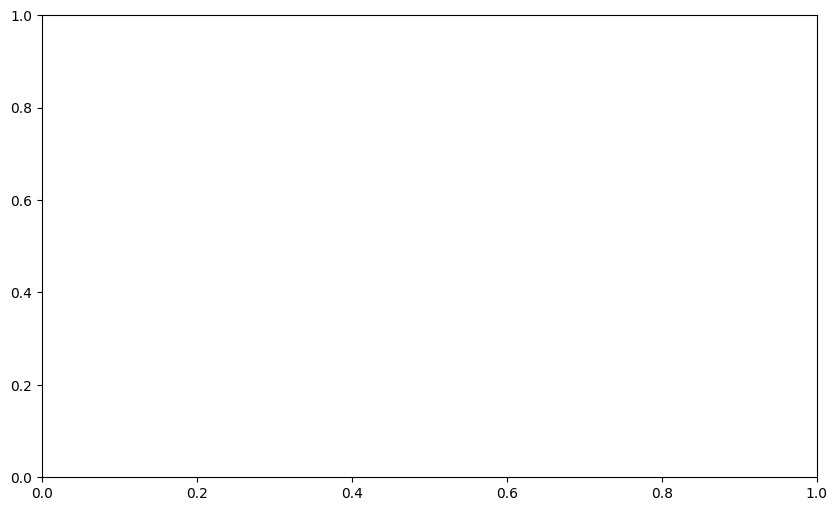

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# 生成一个示例信号：1秒的正弦波
fs = 1024  # 采样频率
t = np.linspace(0, 1, fs)
signal = .5 * np.sin(2 * np.pi * 100 * t)  # 100Hz 正弦波

# 转换为 PyTorch 张量
signal_tensor = torch.tensor(signal, dtype=torch.float32)
print(signal_tensor)
# STFT 参数
n_fft = 256
hop_length = 128
win_length = 256
window = torch.hann_window(win_length)

# 计算 STFT
stft_result = torch.stft(signal_tensor, n_fft=n_fft, hop_length=hop_length,
                         win_length=win_length, window=window, return_complex=True)

# 获取幅度谱
magnitude = torch.abs(stft_result)

# 绘制 STFT 幅度谱
plt.figure(figsize=(10, 6))
plt.imshow(magnitude.T.numpy(), aspect='auto', origin='lower', extent=[0, 1, 0, fs / 2])
plt.colorbar(label='Magnitude')
plt.ylabel('Frequency (Hz)')
plt.xlabel('Time (s)')
plt.title('STFT Magnitude Spectrum')
plt.show()

In [10]:
# -*- coding: utf-8 -*-
"""
Mahalanobis module
--------------------------
"""
import torch
import torch.nn as nn

class MahalanobisLayer(nn.Module):

    def __init__(self, dim, decay = 0.1):
        super(MahalanobisLayer, self).__init__()
        self.S = torch.eye(dim)
        self.S_inv = torch.eye(dim)
        self.decay = decay

    def forward(self, x, x_fit):
        """
        Calculates the squared Mahalanobis distance between x and x_fit
        """

        delta = x - x_fit
        m = torch.matmul(torch.matmul(delta, self.S_inv), delta.t())
        return torch.diag(m)

    def cov(self, x):
        x -= torch.mean(x, dim=0)
        return 1 / (x.size(0) - 1) * x.t().matmul(x)

    def update(self, X, X_fit):
        """更新过程会让S渐渐接近于样本X和参考点X_fit的差值(delta = X - X_fit)的协方差。
        """
        delta = X - X_fit
        self.S = (1 - self.decay) * self.S + self.decay * self.cov(delta)
        self.S_inv = torch.pinverse(self.S)

if __name__ == "__main__":

    from scipy.spatial import distance
    import numpy as np

    # Some example data for testing
    v  = torch.Tensor([[1, 0.5, 0.5], [0.5, 1, 0.5], [0.5, 0.5, 1]])
    iv = torch.inverse(v)
    X1 = torch.Tensor([[1, 0, 0], [0, 1, 0], [0, 2, 0]])
    X2 = torch.Tensor([[0, 1, 0], [0, 2, 0], [0, 2, 0]])

    # Squared Mahalanobis distance using scipy
    scipy_dist_list = [distance.mahalanobis(x1.numpy(), x2.numpy(), iv.numpy()) for x1, x2 in zip(X1, X2)]
    scipy_dist = np.array(scipy_dist_list)**2

    # Mahalanobis distance pytorch implementation
    mah_layer = MahalanobisLayer(3, decay=0.99)
    mah_layer.S_inv = iv

    pytorch_dist = mah_layer(X1, X2)

     # Check if almost equal
    np.testing.assert_almost_equal(scipy_dist, pytorch_dist.numpy())

    # Covariance method
    X = torch.rand(10, 3)
    np_cov_X = np.cov(X.numpy(), rowvar=False)
    pytorch_cov_X = mah_layer.cov(X)

    # Check if almost equal
    np.testing.assert_almost_equal(np_cov_X, pytorch_cov_X.numpy())

    # Update method
    X_fit = torch.rand(10, 3)
    delta = X - X_fit
    np_cov_delta = np.cov(delta.numpy(), rowvar=False)
    pytorch_cov_delta = mah_layer.cov(delta)
    np.testing.assert_almost_equal(np_cov_delta, pytorch_cov_delta.numpy())

    # Check if almost equal after enough updates
    for i in range(20):
        mah_layer.update(X, X_fit)
    np.testing.assert_almost_equal(np_cov_delta, mah_layer.S.numpy())

    # Test if numpy inverse and pytorch pseudo inverse are close
    np.testing.assert_almost_equal(np.linalg.inv(np_cov_delta), mah_layer.S_inv.numpy(), decimal=5)

In [ ]:
import torch

def mahalanobis_distance(X, centers):
    # 计算协方差矩阵 (features_dim, features_dim)
    # 使用样本 X 估计协方差矩阵并计算逆矩阵
    cov_matrix = torch.cov(X.T)  # 假设 X 沿第0维是样本数，第1维是特征数
    cov_inv = torch.linalg.inv(cov_matrix)  # 计算协方差矩阵的逆

    # 扩展 X 和 centers 的维度以便进行广播计算
    X_expanded = X.unsqueeze(1)  # (batch_size, 1, features_dim)
    centers_expanded = centers.unsqueeze(0)  # (1, num_class, features_dim)

    # 计算每个样本与每个中心之间的差
    diff = X_expanded - centers_expanded  # (batch_size, num_class, features_dim)

    # 计算马氏距离的平方
    # 距离公式：sqrt((x - c)^T * cov_inv * (x - c))
    # 这里计算平方距离以避免开根号的开销
    mahalanobis_squared = torch.einsum('bcd,de,bce->bc', diff, cov_inv, diff)

    # 返回距离 (batch_size, num_class)
    return torch.sqrt(mahalanobis_squared)

# 示例数据
batch_size, features_dim, num_class = 32, 128, 10
X = torch.randn(batch_size, features_dim)
centers = torch.randn(num_class, features_dim)

# 计算马氏距离
distances = mahalanobis_distance(X, centers)
print(distances.shape)  # 应该输出 (batch_size, num_class)
print(distances)


torch.Size([32, 10])
tensor([[       nan,        nan,        nan, 27409.7793,        nan,        nan,
                nan, 15270.6250,        nan,        nan],
        [       nan,        nan,        nan, 27409.7891,        nan,        nan,
                nan, 15270.6045,        nan,        nan],
        [       nan,        nan,        nan, 27409.7773,        nan,        nan,
                nan, 15270.5928,        nan,        nan],
        [       nan,        nan,        nan, 27409.8105,        nan,        nan,
                nan, 15270.6182,        nan,        nan],
        [       nan,        nan,        nan, 27409.7930,        nan,        nan,
                nan, 15270.6240,        nan,        nan],
        [       nan,        nan,        nan, 27409.7812,        nan,        nan,
                nan, 15270.5957,        nan,        nan],
        [       nan,        nan,        nan, 27409.7910,        nan,        nan,
                nan, 15270.6045,        nan,        nan],
      

In [4]:
import numpy as np

# 示例二维ndarray
arr = np.random.rand(5, 3)  # 创建一个5x3的二维数组

# Z-Score 标准化
arr_standardized = (arr - arr.mean(axis=0)) / arr.std(axis=0)

print(arr_standardized)

# 最小-最大归一化
arr_normalized = (arr - arr.min(axis=0)) / (arr.max(axis=0) - arr.min(axis=0))

print(arr_normalized)



def normalize_to_range(matrix: np.ndarray, a, b, axis=0):
    """
    将数据归一化到指定的范围 [a, b]
    """
    # 计算数据的最小值和最大值
    min_val = matrix.min(axis=0)
    max_val = matrix.max(axis=0)
    
    # 归一化公式
    return a + (matrix - min_val) * (b - a) / (max_val - min_val) 

# 示例数据
data = np.random.rand(3, 4)
print(data)

# 归一化到 [0, 1] 范围
normalized_data_0_1 = normalize_to_range(data, 0, 1)
print("归一化到 [0, 1]:", normalized_data_0_1)

# 归一化到 [-1, 1] 范围
normalized_data_minus1_1 = normalize_to_range(data, -1, 1)
print("归一化到 [-1, 1]:", normalized_data_minus1_1)

# 归一化到 [10, 20] 范围
normalized_data_10_20 = normalize_to_range(data, 10, 20)
print("归一化到 [10, 20]:", normalized_data_10_20)



[[-1.66752185 -1.34429169  0.73768066]
 [ 1.20680026  0.51541657  1.24121191]
 [ 0.0030893   0.62537553 -1.49405552]
 [-0.34489145 -1.01972802  0.28931678]
 [ 0.80252373  1.22322762 -0.77415383]]
[[0.         0.         0.81591151]
 [1.         0.72432104 1.        ]
 [0.58121918 0.76714797 0.        ]
 [0.46015386 0.12641138 0.65199193]
 [0.85934891 1.         0.26319243]]
[[0.77532853 0.45971716 0.20698515 0.73934547]
 [0.69050825 0.749755   0.17331201 0.47961225]
 [0.49453489 0.07784619 0.19549354 0.92409771]]
归一化到 [0, 1]: [[1.         0.5683375  1.         0.58434581]
 [0.69792663 1.         0.         0.        ]
 [0.         0.         0.65873067 1.        ]]
归一化到 [-1, 1]: [[ 1.          0.136675    1.          0.16869162]
 [ 0.39585325  1.         -1.         -1.        ]
 [-1.         -1.          0.31746134  1.        ]]
归一化到 [10, 20]: [[20.         15.683375   20.         15.8434581 ]
 [16.97926627 20.         10.         10.        ]
 [10.         10.         16.5873067  20.

In [7]:
import torch

# 示例数据
bs = 16  # batch size
original_dim = 3712  # 原始特征维度
target_dim = 128  # 降维后的目标维度
A = torch.rand(bs, original_dim)  # bs × 3712 输入矩阵

# SVD 分解
U, S, Vh = torch.linalg.svd(A, full_matrices=False)  # full_matrices=False 保持矩阵紧凑
print(U.shape, S.shape, Vh.shape)
print(S)

# 获取前 128 个右奇异向量
V_k = Vh[:target_dim, :]  # Shape: 128 × 3712
print(V_k.shape)

# 降维
A_lowdim = torch.matmul(A, V_k.T)  # Shape: bs × 128

print("降维后的矩阵形状:", A_lowdim.shape)


torch.Size([16, 16]) torch.Size([16]) torch.Size([16, 3712])
tensor([122.9405,  18.3659,  18.3183,  18.1921,  18.1441,  17.9775,  17.7609,
         17.6385,  17.5347,  17.4124,  17.2192,  17.1543,  17.0958,  17.0253,
         16.8236,  16.5582])
torch.Size([16, 3712])
降维后的矩阵形状: torch.Size([16, 16])


In [1]:
import torch
import torch.nn as nn

# 输入张量，大小为 (batch_size, length)
x = torch.randn(8, 3712)

# 定义 MaxPool1d
pool = nn.MaxPool1d(kernel_size=29, stride=29)

# 输入需要 (batch_size, channels, length)，所以需要增加一个维度
x = x.unsqueeze(1)  # (8, 1, 3712)

# 应用 MaxPool1d
output = pool(x)

# 去掉多余的通道维度，得到 (8, 128)
output = output.squeeze(1)

print("输出张量大小:", output.shape)


输出张量大小: torch.Size([8, 128])


In [1]:
import numpy as np
from scipy.stats import weibull_min

# 模拟 logits 输出
logits = np.array([5.2, 4.8, 2.1, 0.3])

# 拟合 Weibull 分布
def fit_weibull(data, tail_size=20):
    tail_data = np.sort(data)[-tail_size:]
    params = weibull_min.fit(tail_data, floc=0)  # 固定位置参数为0
    return params

# 计算未知类概率
def compute_openmax(logits, weibull_params, alpha=0.5):
    weibull_probs = weibull_min.cdf(logits, *weibull_params)
    adjusted_logits = logits * (1 - alpha * weibull_probs)
    unknown_prob = alpha * np.sum(weibull_probs)
    return adjusted_logits / np.sum(adjusted_logits + unknown_prob), unknown_prob

# 应用 OpenMax
weibull_params = fit_weibull(logits)
openmax_probs, unknown_prob = compute_openmax(logits, weibull_params)
print("OpenMax Probabilities:", openmax_probs)
print("Unknown Probability:", unknown_prob)


OpenMax Probabilities: [0.25151812 0.2385841  0.13715605 0.0243315 ]
Unknown Probability: 1.0507136930072312


In [5]:
from scipy.stats import genextreme
import numpy as np

# 模拟特征嵌入和类别中心
features = np.random.randn(100, 128)  # 100个样本，128维特征
class_centers = np.mean(features[:50], axis=0)  # 假设前50个样本为一个类别

# 计算欧几里得距离
distances = np.linalg.norm(features - class_centers, axis=1)

print(distances)

# 极值分布拟合
params = genextreme.fit(distances)
threshold = genextreme.ppf(0.95, *params)  # 95%置信区间

print(params)
print(threshold)

# 判定未知类
is_unknown = distances > threshold
print("Unknown Samples:", np.sum(is_unknown))


[10.01874175 11.76571703 10.58459869 11.61570557 11.21244446 10.52630716
 11.09870516 10.76711366 10.89501091 12.32151988 12.5795593  10.83433527
 11.38221591 10.7924245  11.12731775 10.70461625 11.82805647 11.38345948
 11.66753593 10.77452181 12.22715917 11.83175608 10.98122375 10.39863107
  9.06585123 11.09347382 10.96421381 11.48040476 11.68577522 11.60441552
 11.79457471 10.89300404 10.15933623 12.12547682 10.73686614 11.13002006
 11.49314911 10.73224076 10.9001735  11.28216874 11.78818773  9.77414735
 11.44855676 11.10519248 11.64153779 11.32703733 11.13165524 10.87437316
 12.0591956  10.24899812 12.86040043 11.79688388 10.61788741 11.59135318
 12.46674211 10.84673819 12.11190916 11.97468296 11.72750004 12.21413406
 11.1555743  12.24774043 11.38473073 11.24376168 11.63972657 10.08083924
 11.64481403 11.70709865 12.41056868 11.02839886 12.33312232 11.53808386
 10.88979158 11.32265164 11.87626803 10.63156648 10.33319771 10.83257812
 12.54859864 11.56716153 12.89491643 10.88661108 10

In [6]:
import torch
import torch.nn as nn

def calculate_distance(centers: nn.Parameter, feature: torch.Tensor, mode="mahalanobis") -> torch.Tensor:
    """计算特征向量到所有聚类中心的平方马氏距离
    Args:
        centers (nn.Parameter): 聚类中心向量 [num_class, features_dim]
        feature (torch.Tensor): 特征向量 [1, features_dim]
    Returns:
        torch.Tensor: 特征向量到每个聚类中心的马氏距离 [num_class(seen), 1]
    """
    if mode == "euclidan":
        return torch.stack([torch.norm(feature - center, p=2) for center in centers])
    elif mode == "manhattan":
        return torch.stack([torch.norm(feature - center, p=1) for center in centers])

centers = torch.rand((10, 128))
feature = torch.rand((128))
print(calculate_distance(centers, feature, mode="euclidan"))
print(calculate_distance(centers, feature, mode="manhattan"))


tensor([4.6354, 4.4105, 4.4418, 4.7746, 4.4876, 4.4894, 3.9661, 4.8454, 4.2868,
        4.3154])
tensor([42.6876, 40.2674, 41.4844, 44.9314, 42.3701, 41.6341, 36.9546, 44.5891,
        39.2722, 37.7717])


In [7]:
import numpy as np
import torch
# 假设输入矩阵为 X，大小为 (16, 1024)
np.random.seed(42)  # 保持结果可重复
X = np.random.rand(16, 1024)

# SVD 分解
U, S, Vt = np.linalg.svd(X, full_matrices=False)

# 保留前 16 个奇异值对应的成分
U_reduced = U[:, :10]  # 左奇异向量
S_reduced = np.diag(S[:10])  # 奇异值矩阵（对角阵）
Vt_reduced = Vt[:10, :]  # 右奇异向量

# 得到降维后的矩阵（映射到低维空间）
X_reduced = np.dot(U_reduced, S_reduced)

# 如果需要恢复降维后的近似矩阵，可以使用以下方式
X_approx = np.dot(X_reduced, Vt_reduced)

print("Original Shape:", X.shape)
print("Reduced Shape:", X_reduced.shape)
print("Approximated Shape:", X_approx.shape)
print(torch.dist(torch.Tensor(X), torch.Tensor(X_approx)))
print(X)
print(X_approx)

Original Shape: (16, 1024)
Reduced Shape: (16, 10)
Approximated Shape: (16, 1024)
tensor(21.0944)
[[0.37454012 0.95071431 0.73199394 ... 0.29734901 0.9243962  0.97105825]
 [0.94426649 0.47421422 0.86204265 ... 0.7228143  0.06766836 0.7078351 ]
 [0.54353822 0.08172535 0.45830064 ... 0.67602629 0.70662987 0.61000742]
 ...
 [0.18655791 0.63634432 0.50009234 ... 0.24051204 0.30666863 0.96157897]
 [0.57847325 0.98759577 0.37246695 ... 0.92701211 0.39837768 0.31909534]
 [0.887142   0.0492444  0.13638539 ... 0.59986797 0.52649853 0.5162331 ]]
[[0.38563325 0.93318332 0.64777004 ... 0.14552541 0.85137964 0.8501877 ]
 [0.95952628 0.48569005 0.87120395 ... 0.8054927  0.12872458 0.71514665]
 [0.57250968 0.06350062 0.43459888 ... 0.50661032 0.55204896 0.73501694]
 ...
 [0.17838214 0.47521749 0.4068248  ... 0.34625473 0.51758096 0.79919515]
 [0.4686142  0.87526944 0.4965454  ... 0.93479001 0.58163588 0.30097545]
 [0.73749571 0.19512569 0.3627128  ... 0.58038754 0.57141379 0.43752195]]


In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SharedDropout(nn.Module):
    def __init__(self, p=0.5):
        super(SharedDropout, self).__init__()
        self.p = p
        self.scale = 1.0 / (1.0 - p)  # 为了保持输出期望值不变

    def forward(self, x1, x2):
        # 生成相同的掩码 (同样的随机掩码)
        if self.training:  # 只在训练模式下使用 dropout
            mask = (torch.rand_like(x1) > self.p).float()  # 生成0和1的掩码
            mask = mask * self.scale  # 对保留的单元进行缩放
            # 应用相同的掩码到两个输入上
            x1 = x1 * mask
            x2 = x2 * mask
        return x1, x2

# 测试代码
x1 = torch.randn(10)  # 假设是第一个输入
x2 = torch.randn(10)  # 假设是第二个输入

dropout_layer = SharedDropout(p=0.3)  # 创建共享Dropout层，丢弃概率为30%

# 训练模式下
dropout_layer.train()

out1, out2 = dropout_layer(x1, x2)
print(out1)
print(out2)


tensor([-1.0697,  0.5385,  0.0000,  0.3007,  2.6710,  0.0000, -3.6726, -0.1665,
         0.3158,  1.4074])
tensor([ 1.0392, -0.5477, -0.0000, -2.2065, -0.7184,  0.0000,  0.7324,  1.9952,
         1.8829, -0.5398])


In [4]:
import torch
import torch.nn.functional as F
from torch import nn

__all__ = ['InfoNCE', 'info_nce']


class InfoNCE(nn.Module):
    """
    Calculates the InfoNCE loss for self-supervised learning.
    This contrastive loss enforces the embeddings of similar (positive) samples to be close
        and those of different (negative) samples to be distant.
    A query embedding is compared with one positive key and with one or more negative keys.

    References:
        https://arxiv.org/abs/1807.03748v2
        https://arxiv.org/abs/2010.05113

    Args:
        temperature: Logits are divided by temperature before calculating the cross entropy.
        reduction: Reduction method applied to the output.
            Value must be one of ['none', 'sum', 'mean'].
            See torch.nn.functional.cross_entropy for more details about each option.
        negative_mode: Determines how the (optional) negative_keys are handled.
            Value must be one of ['paired', 'unpaired'].
            If 'paired', then each query sample is paired with a number of negative keys.
            Comparable to a triplet loss, but with multiple negatives per sample.
            If 'unpaired', then the set of negative keys are all unrelated to any positive key.

    Input shape:
        query: (N, D) Tensor with query samples (e.g. embeddings of the input).
        positive_key: (N, D) Tensor with positive samples (e.g. embeddings of augmented input).
        negative_keys (optional): Tensor with negative samples (e.g. embeddings of other inputs)
            If negative_mode = 'paired', then negative_keys is a (N, M, D) Tensor.
            If negative_mode = 'unpaired', then negative_keys is a (M, D) Tensor.
            If None, then the negative keys for a sample are the positive keys for the other samples.

    Returns:
         Value of the InfoNCE Loss.

     Examples:
        >>> loss = InfoNCE()
        >>> batch_size, num_negative, embedding_size = 32, 48, 128
        >>> query = torch.randn(batch_size, embedding_size)
        >>> positive_key = torch.randn(batch_size, embedding_size)
        >>> negative_keys = torch.randn(num_negative, embedding_size)
        >>> output = loss(query, positive_key, negative_keys)
    """

    def __init__(self, temperature=0.1, reduction='mean', negative_mode='unpaired'):
        super().__init__()
        self.temperature = temperature
        self.reduction = reduction
        self.negative_mode = negative_mode

    def forward(self, query, positive_key, negative_keys=None):
        return info_nce(query, positive_key, negative_keys,
                        temperature=self.temperature,
                        reduction=self.reduction,
                        negative_mode=self.negative_mode)


def info_nce(query, positive_key, negative_keys=None, temperature=0.1, reduction='mean', negative_mode='unpaired'):
    # Check input dimensionality.
    if query.dim() != 2:
        raise ValueError('<query> must have 2 dimensions.')
    if positive_key.dim() != 2:
        raise ValueError('<positive_key> must have 2 dimensions.')
    if negative_keys is not None:
        if negative_mode == 'unpaired' and negative_keys.dim() != 2:
            raise ValueError("<negative_keys> must have 2 dimensions if <negative_mode> == 'unpaired'.")
        if negative_mode == 'paired' and negative_keys.dim() != 3:
            raise ValueError("<negative_keys> must have 3 dimensions if <negative_mode> == 'paired'.")

    # Check matching number of samples.
    if len(query) != len(positive_key):
        raise ValueError('<query> and <positive_key> must must have the same number of samples.')
    if negative_keys is not None:
        if negative_mode == 'paired' and len(query) != len(negative_keys):
            raise ValueError("If negative_mode == 'paired', then <negative_keys> must have the same number of samples as <query>.")

    # Embedding vectors should have same number of components.
    if query.shape[-1] != positive_key.shape[-1]:
        raise ValueError('Vectors of <query> and <positive_key> should have the same number of components.')
    if negative_keys is not None:
        if query.shape[-1] != negative_keys.shape[-1]:
            raise ValueError('Vectors of <query> and <negative_keys> should have the same number of components.')

    # Normalize to unit vectors
    query, positive_key, negative_keys = normalize(query, positive_key, negative_keys)
    if negative_keys is not None:
        # Explicit negative keys

        # Cosine between positive pairs
        positive_logit = torch.sum(query * positive_key, dim=1, keepdim=True)

        if negative_mode == 'unpaired':
            # Cosine between all query-negative combinations
            negative_logits = query @ transpose(negative_keys)

        elif negative_mode == 'paired':
            query = query.unsqueeze(1)
            negative_logits = query @ transpose(negative_keys)
            negative_logits = negative_logits.squeeze(1)

        # First index in last dimension are the positive samples
        logits = torch.cat([positive_logit, negative_logits], dim=1)
        labels = torch.zeros(len(logits), dtype=torch.long, device=query.device)
    else:
        # Negative keys are implicitly off-diagonal positive keys.

        # Cosine between all combinations
        logits = query @ transpose(positive_key)

        # Positive keys are the entries on the diagonal
        labels = torch.arange(len(query), device=query.device)

    return F.cross_entropy(logits / temperature, labels, reduction=reduction)


def transpose(x):
    return x.transpose(-2, -1)


def normalize(*xs):
    return [None if x is None else F.normalize(x, dim=-1) for x in xs]


# Example usage
B = 4  # Batch size
D = 128  # Feature dimension
N = 10  # Number of negative samples

loss_1 = InfoNCE(negative_mode='paired')

# Query and positive_key have shape (B, D)
query = torch.randn(B, D)
positive_key = torch.randn(B, D)

# Negative keys have shape (B, N, D), with N negative samples per query
negative_keys = torch.randn(B, N, D)

loss = loss_1(query, positive_key, negative_keys=negative_keys)
print(f"InfoNCE Loss: {loss.item()}")

InfoNCE Loss: 2.803877115249634
